# Exploring Twitter Data from Congress Member

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import dill
from datetime import datetime, timedelta
from pandas.io.json import json_normalize
# from fuzzywuzzy import fuzz
# from fuzzywuzzy import process

In [2]:
plt.style.use('seaborn')

# Getting twitter data

In [3]:
# get dates from website
base_url = 'https://alexlitel.github.io'
url = 'https://alexlitel.github.io/congresstweets/'
r = requests.get(url)

soup = BeautifulSoup(r.text, 'html5lib')
links = []
for link in soup.select('div.post.py2 a[href]'):
    links.append(link.get('href'))

In [4]:
# old code

# df = pd.DataFrame()

# for link in links:
#     file = requests.get(base_url+link).json()
#     df = df.append(pd.DataFrame(file)) 

In [5]:
from requests_futures.sessions import FuturesSession

session = FuturesSession(max_workers=5)
futures = [session.get(base_url+link) for link in links]

In [6]:
# get data
df = pd.DataFrame()
for file in futures: 
   df = df.append(pd.DataFrame(file.result().json()))    

df.shape

(165848, 7)

In [7]:
df['date'] = pd.to_datetime(df.time)
df.set_index('date', inplace=True)
#df.head()

In [8]:
# number of tweets per day
# df.text.resample('D').count().plot();
# plt.savefig('tweets_day.png')

In [9]:
#dill.dump(df, open('tweets.pkd', 'wb'))

In [10]:
#df = dill.load(open('tweets.pkd', 'rb'))

In [11]:
# old code
# dates = [ start_date + timedelta(n) for n in range(int ((end_date - start_date).days))]
# dates = pd.to_datetime(dates)
# dates = dates.strftime('%Y-%m-%d')

# # get data
# urls = [('https://alexlitel.github.io/congresstweets/data/' + i + '.json') for i in dates]
# df = pd.DataFrame()
# for i in urls:
#     r = requests.get(i).json()
#     df = df.append(pd.DataFrame(r))

# Reading Metadata and Match Screen Names

In [12]:
# read metadata
url = "https://raw.githubusercontent.com/alexlitel/congresstweets-automator/master/data/users-filtered.json"
r = requests.get(url).json()
m = json_normalize(r)
m = m.loc[m.type=='member'] # only members

In [13]:
m.accounts.isnull().value_counts() # no missing records
m['user_id'] =  m.accounts.map(lambda x:  x[0]['id'])
m['govtrack'] = m.id.map(lambda x:  x['govtrack'])
m = m.loc[:,['user_id', 'govtrack', 'name', 'chamber', 'party', 'state']]
m.head()

,user_id,govtrack,name,chamber,party,state
33,37007274,400440,Don Young,house,R,AK
34,2253968388,412601,Bradley Byrne,house,R,AL
35,2861616083,412608,Gary Palmer,house,R,AL
36,224294785,412394,Martha Roby,house,R,AL
37,33977070,400341,Mike Rogers,house,R,AL


In [14]:
# old code
# meta = pd.melt(m, id_vars=['chamber', 'id.govtrack', 'name', 'party', 'state'], 
#                value_vars=['name1', 'name2'])


# meta.rename(columns={'value':'mnames'}, inplace=True)
# meta = meta[meta.mnames.notnull()]
# meta.head()

# explore some screen names
#meta.loc[meta.mnames == 'auctnr1',:]
# meta.loc[meta.name.str.contains('Bill'),:]

#choices = meta.loc[:,'mnames'].tolist()

#queries = df.loc[:,'screen_name'].tolist()
#queries = list(set(queries)) # remove duplicates

#[re.search(r'auctnr1', q) for q in choices]
#len(queries)

#t = map(lambda q : process.extractOne(q, choices, score_cutoff=80), queries)
#t = list(t)

## extract names
#names = [x[0] if x is not None else None for x in t]
#score = [x[1] if x is not None else None for x in t]
3# create dataframe
#name_match = pd.DataFrame({'screen_name': queries,'mnames': names, 'score_match' : score})
#name_match.head()

#name_match = name_match[name_match.score_match.notnull()]
#name_match.shape

#name_match[name_match.score_match < 100]

3

In [15]:
# merge
dat = pd.merge(df, m, on='user_id', how='left')

null_match = dat.name.isnull()
null_match.value_counts()

match_names = dat.loc[-null_match,'name'].unique() # 515, okey, not that bad

nonmatch_names = dat.loc[null_match,'screen_name'].unique()

In [16]:
len(match_names)

515

In [17]:
# examine

list(filter(None,[re.findall(r'Rand', name) for name in  match_names]))

[['Rand'], ['Rand'], ['Rand']]

In [18]:
dat = dat.loc[-null_match,:]
dat.shape

(117659, 12)

# Some plots

In [19]:
# plotting
dat['date'] = pd.to_datetime(dat.time)
dat.set_index('date', inplace=True)

In [20]:
# old code
# dat.loc[:, ['name', 'party', 'mnames', 'score_match']].head()
#dat.loc[dat.name.str.contains('Long'), 'mnames'].value_counts() # most of cases come from auctnrl

In [21]:
nt = dat.groupby('name').count().id
nt[nt > 1000]

name
Don Beyer              2324
Ileana Ros-Lehtinen    1346
Keith Ellison          1080
Lacy Clay              1260
Pramila Jayapal        1842
Name: id, dtype: int64

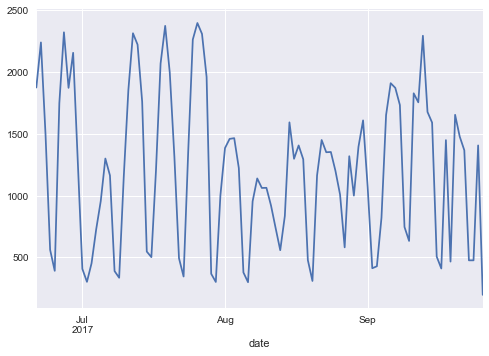

In [22]:
dat.text.resample('D').count().plot();

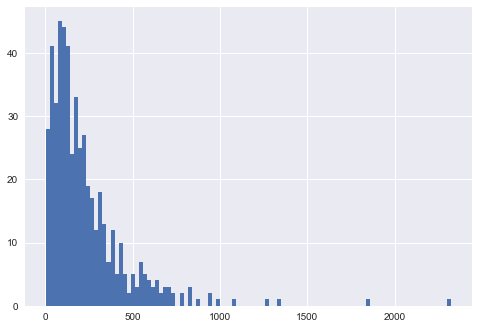

In [23]:
# plot distribution number of tweets per member
nt.hist(bins=100);

In [24]:
# descriptives members' tweets
dat.party.value_counts()

D    70135
R    46910
I      614
Name: party, dtype: int64

In [25]:
dat.chamber.value_counts()

house     85961
senate    31698
Name: chamber, dtype: int64

In [26]:
# save object
dill.dump(dat, open('tweets.pkd', 'wb'))